In [1]:
%matplotlib inline

import sys, os, copy, warnings, time
import qinfer as qi
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import display, Math, Latex

from scipy.stats import iqr

In [2]:
%run allmyfonts.py

Fonts loaded


data exported in C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\Qinfer_Sensing\test_results\QHL_sensing_tracking\SinsusoidalSweep_simulation_infid_alldata___2018-04-29_18.03.46.pk

In [3]:
dire = os.getcwd()
dire = dire+"/test_results/"+"/QHL_sensing_tracking"
#dire = os.path.join("..","Efficient sensing", "Figures", "Figures for paper")
dire = os.path.normpath(dire)
print('Files will be saved in:')
print(dire)

Files will be saved in:
C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\Qinfer_Sensing\test_results\QHL_sensing_tracking


In [4]:
%run nv_sensing_lib.py

# Single run

In [5]:
resample_thresh = 0.4
resample_a =0.92

timestamp = mytimestamp()

n_runs = 1

In [16]:
n_particles = 2000
n_experiments = 1500

omegabounds = [0, 1]

output = []

start = time.time()


#run = TrackPrecModel(freq_min=omegabounds[0], freq_max=omegabounds[1], n_particles=n_particles, 
#                        timedep = "Sin", noise=None, start = np.array([[0.5]]), freq_rate = 0.1, amplitude = 0.02)
#run = TrackPrecModel(freq_min=omegabounds[0], freq_max=omegabounds[1], n_particles=n_particles, 
#                        timedep = "Sin", noise='Binomial', start = np.array([[0.5]]), freq_rate = 0.1, amplitude = 0.02)
run = TrackPrecModel(freq_min=omegabounds[0], freq_max=omegabounds[1], n_particles=n_particles, 
                        timedep = "InfidSin", fids=(1, 0.75), start = np.array([[0.5]]), freq_rate = 0.05, amplitude = 0.02)

for run_idx in range(n_runs):

    output.append(
        run.est_prec(data = None, resample_a = resample_a, resample_thresh = resample_thresh, 
                     n_experiments = n_experiments, verbose=False)
          )    

    simtimes = np.arange(1, n_experiments+1, 1)*convertms

print("Elapsed time: " + str(time.time()-start) + " secs")
npoutput=np.array([output])

Elapsed time: 1.0789999961853027 secs


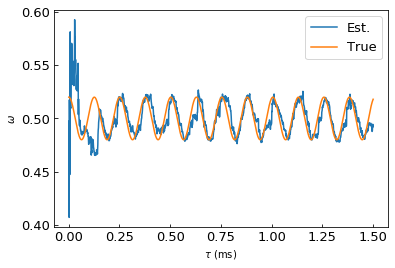

In [17]:
plt.plot(simtimes, npoutput[0, 0, 0], label='Est.')
plt.plot(simtimes, npoutput[0, 0, -1], label='True')
plt.legend(loc='upper right')
plt.xlabel(r'$\tau$ (ms)')
plt.ylabel(r'$\omega$')


plt.show()

In [19]:
idfreq=0.13

In [20]:
prova = TrackPrecModel(freq_min=omegabounds[0], freq_max=omegabounds[1], n_particles=n_particles, 
                        timedep = "Sin", start = np.array([[0.5]]), freq_rate = idfreq, amplitude = 0.02)

In [21]:
prova.prior = qi.UniformDistribution([prova.freq_min, prova.freq_max])
prova.updater = qi.SMCUpdater(prova.model, prova.n_particles, prova.prior, resample_a=resample_a, resample_thresh=resample_thresh)
prova.heuristic = stdPGH(prova.updater, inv_field='w_')    

In [22]:
experiment = prova.heuristic()
print(experiment)
prova.true_params = prova.start

[( 19.22050651,  0.09404886)]


# Multiple runs (sweep of frequencies)

In [21]:
allfreqrates = np.arange(0.001, 0.26, 0.005)
print(len(allfreqrates), allfreqrates)

52 [ 0.001  0.006  0.011  0.016  0.021  0.026  0.031  0.036  0.041  0.046
  0.051  0.056  0.061  0.066  0.071  0.076  0.081  0.086  0.091  0.096
  0.101  0.106  0.111  0.116  0.121  0.126  0.131  0.136  0.141  0.146
  0.151  0.156  0.161  0.166  0.171  0.176  0.181  0.186  0.191  0.196
  0.201  0.206  0.211  0.216  0.221  0.226  0.231  0.236  0.241  0.246
  0.251  0.256]


In [22]:
resample_thresh = 0.4
resample_a =0.92

timestamp = mytimestamp()

n_runs = 100

n_particles = 2000
n_experiments = 2000

omegabounds = [0, 1]

convertms = 1/1000
algotimes = np.linspace( 0, 1.86/n_experiments, n_experiments) # in s

## simulations with NO NOISE

In [25]:
sweep_outputs = dict(zip(allfreqrates, [None for i in allfreqrates]))

In [26]:
for idfreq in allfreqrates:
    
    output = []
    
    start = time.time()
    
    run = TrackPrecModel(freq_min=omegabounds[0], freq_max=omegabounds[1], n_particles=n_particles, 
                        timedep = "Sin", start = np.array([[0.5]]), freq_rate = idfreq, amplitude = 0.02)

    for run_idx in range(n_runs):

        output.append(
            run.est_prec(data = None, resample_a = resample_a, resample_thresh = resample_thresh, 
                         n_experiments = n_experiments, verbose=False)
              )
        
    npoutput=np.array([output])
    
    meanW = np.mean(npoutput[0,:,0], axis=0)
    medW = np.median(npoutput[0,:,0], axis=0)
    
    trueW = np.mean(npoutput[0,:,-1], axis=0)
    
    stdevW = np.std(npoutput[0,:,0], axis=0)
    iqrW = iqr(npoutput[0,:,0], axis=0, rng=(50-68.27/2, 50+68.27/2))
        
    medcov = radfreq_to_B(np.median(npoutput[0,:,2], axis=0))

    errWsup = np.empty(len(meanW))
    errWinf = np.empty(len(meanW))

    iqrWsup = np.empty(len(meanW))
    iqrWinf = np.empty(len(meanW))
    
    for i in range(len(meanW)):
        iqrWinf[i] = ( 
            iqr(npoutput[0,:,0,i][npoutput[0,:,0,i]<np.median(npoutput[0,:,0,i])], rng=(100-68.27, 100)) )
        iqrWsup[i] = ( 
            iqr(npoutput[0,:,0,i][npoutput[0,:,0,i]>np.median(npoutput[0,:,0,i])], rng=(0, 68.27)) )

    for i in range(len(meanW)):
        errWinf[i] = ( 
            np.std(npoutput[0,:,0,i][npoutput[0,:,0,i]<np.median(npoutput[0,:,0,i])]) )
        errWsup[i] = ( 
            np.std(npoutput[0,:,0,i][npoutput[0,:,0,i]>np.median(npoutput[0,:,0,i])]) )
    
    acctimes = np.mean(npoutput[0,:,3], axis=0)*convertms
#     print("Max accumulated time (ms): " + str(max(acctimes)) )
        
    meanQL = np.mean(npoutput[0,:,1], axis=0)
    medQL = np.median(npoutput[0,:,1], axis=0)
    errQL = np.std(npoutput[0,:,1], axis=0)
    iqrQL = iqr(npoutput[0,:,1], axis=0, rng=(50-68.27/2, 50+68.27/2)) 

    errQLsup = np.empty(len(errQL))
    errQLinf = np.empty(len(errQL))

    iqrQLsup = np.empty(len(iqrQL))
    iqrQLinf = np.empty(len(iqrQL))
    
    for i in range(len(iqrQL)):
        iqrQLinf[i] = iqr(npoutput[0,:,1,i][npoutput[0,:,1,i]<np.median(npoutput[0,:,1,i])], rng=(100-68.27, 100))
        iqrQLsup[i] = iqr(npoutput[0,:,1,i][npoutput[0,:,1,i]>np.median(npoutput[0,:,1,i])], rng=(0, 68.27)) 

    for i in range(len(errQL)):
        errQLinf[i] = np.std(npoutput[0,:,1,i][npoutput[0,:,1,i]<np.median(npoutput[0,:,1,i])]) 
        errQLsup[i] = np.std(npoutput[0,:,1,i][npoutput[0,:,1,i]>np.median(npoutput[0,:,1,i])]) 

    
    print("Mean Q.L. along tracking = " + str( np.mean(meanQL) )  )
    print("Final Q.L. = " + str( meanQL[-1] )  )
    
    sweep_outputs[idfreq] = {

        'meanW' : meanW, 
        'medW' : medW, 
        'stdevW' : stdevW,
        'iqrW' : iqrW,
        
        'trueW' : trueW,
        
        'medcov': medcov,
        
        'errWinf': errWinf,
        'errWsup': errWsup,
        'iqrWinf': iqrWinf,
        'iqrWsup': iqrWsup,

        'acctimes': acctimes,
        'simtimes': np.arange(1, n_experiments+1, 1)*convertms,
        
        'meanQL': meanQL,
        'medQL': medQL,
        'errQL': errQL,
        'iqrQL' : iqrQL,
        'errQLinf': errQLinf,
        'errQLsup': errQLsup,
        'iqrQLinf': iqrQLinf,
        'iqrQLsup': iqrQLsup,    
        
    }
    
    print("Done with sweeps = " + str(idfreq) + ", Elapsed time: " + str(time.time()-start) + " secs")

Mean Q.L. along tracking = 0.000209353319031
Final Q.L. = 0.000109772333151
Done with sweeps = 0.001, Elapsed time: 137.92700004577637 secs
Mean Q.L. along tracking = 0.000122625899407
Final Q.L. = 7.85323452704e-05
Done with sweeps = 0.006, Elapsed time: 138.67000031471252 secs
Mean Q.L. along tracking = 0.000127450953607
Final Q.L. = 4.0505350278e-05
Done with sweeps = 0.011, Elapsed time: 133.6379997730255 secs
Mean Q.L. along tracking = 0.000154605045585
Final Q.L. = 9.39347512434e-06
Done with sweeps = 0.016, Elapsed time: 131.9100000858307 secs
Mean Q.L. along tracking = 0.00012572422569
Final Q.L. = 2.61346766974e-05
Done with sweeps = 0.021, Elapsed time: 130.82000017166138 secs
Mean Q.L. along tracking = 0.000140203910532
Final Q.L. = 4.60362423348e-05
Done with sweeps = 0.026, Elapsed time: 135.7630000114441 secs
Mean Q.L. along tracking = 0.000159237152523
Final Q.L. = 3.58213791041e-05
Done with sweeps = 0.031, Elapsed time: 136.59800004959106 secs
Mean Q.L. along tracking 

C:\Anaconda\lib\site-packages\qinfer\resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 3 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)
C:\Anaconda\lib\site-packages\qinfer\resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 8 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)
C:\Anaconda\lib\site-packages\qinfer\resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 1 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)


Mean Q.L. along tracking = 0.0019599243913
Final Q.L. = 0.00224881931387
Done with sweeps = 0.066, Elapsed time: 141.58500003814697 secs
Mean Q.L. along tracking = 0.00021283959448
Final Q.L. = 6.70114144869e-05
Done with sweeps = 0.071, Elapsed time: 136.34299993515015 secs
Mean Q.L. along tracking = 0.000224709861863
Final Q.L. = 7.8856463263e-05
Done with sweeps = 0.076, Elapsed time: 140.44200015068054 secs
Mean Q.L. along tracking = 0.000238837302915
Final Q.L. = 0.00012718388825
Done with sweeps = 0.081, Elapsed time: 133.2039999961853 secs
Mean Q.L. along tracking = 0.000236148231567
Final Q.L. = 0.00022247548337
Done with sweeps = 0.086, Elapsed time: 132.3710000514984 secs
Mean Q.L. along tracking = 0.000273242292116
Final Q.L. = 0.000180911833091
Done with sweeps = 0.091, Elapsed time: 133.37999987602234 secs
Mean Q.L. along tracking = 0.000249222787621
Final Q.L. = 8.8619301087e-05
Done with sweeps = 0.096, Elapsed time: 133.0199999809265 secs
Mean Q.L. along tracking = 0.00

In [861]:
fileformat = '.pk'
thisfile = 'SinsusoidalSweep_simulation'+"_alldata__"+timestamp
savedata(dire, thisfile, sweep_outputs, fileformat)

C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\Qinfer_Sensing\test_results\QHL_sensing_tracking\SinsusoidalSweep_simulation_alldata___2018-04-26_09.42.13.pk


## simulations with BINOMIAL NOISE

In [27]:
sweep_outputs_binomial = dict(zip(allfreqrates, [None for i in allfreqrates]))

In [28]:
for idfreq in allfreqrates:
    
    output = []
    
    start = time.time()
    
    run = TrackPrecModel(freq_min=omegabounds[0], freq_max=omegabounds[1], n_particles=n_particles, 
                        timedep = "Sin", noise='Binomial', start = np.array([[0.5]]), freq_rate = idfreq, amplitude = 0.02)

    for run_idx in range(n_runs):

        output.append(
            run.est_prec(data = None, resample_a = resample_a, resample_thresh = resample_thresh, 
                         n_experiments = n_experiments, verbose=False)
              )
        
    npoutput=np.array([output])
    
    meanW = np.mean(npoutput[0,:,0], axis=0)
    medW = np.median(npoutput[0,:,0], axis=0)
    
    trueW = np.mean(npoutput[0,:,-1], axis=0)
    
    stdevW = np.std(npoutput[0,:,0], axis=0)
    iqrW = iqr(npoutput[0,:,0], axis=0, rng=(50-68.27/2, 50+68.27/2))
        
    medcov = radfreq_to_B(np.median(npoutput[0,:,2], axis=0))

    errWsup = np.empty(len(meanW))
    errWinf = np.empty(len(meanW))

    iqrWsup = np.empty(len(meanW))
    iqrWinf = np.empty(len(meanW))
    
    for i in range(len(meanW)):
        iqrWinf[i] = ( 
            iqr(npoutput[0,:,0,i][npoutput[0,:,0,i]<np.median(npoutput[0,:,0,i])], rng=(100-68.27, 100)) )
        iqrWsup[i] = ( 
            iqr(npoutput[0,:,0,i][npoutput[0,:,0,i]>np.median(npoutput[0,:,0,i])], rng=(0, 68.27)) )

    for i in range(len(meanW)):
        errWinf[i] = ( 
            np.std(npoutput[0,:,0,i][npoutput[0,:,0,i]<np.median(npoutput[0,:,0,i])]) )
        errWsup[i] = ( 
            np.std(npoutput[0,:,0,i][npoutput[0,:,0,i]>np.median(npoutput[0,:,0,i])]) )
    
    acctimes = np.mean(npoutput[0,:,3], axis=0)*convertms
#     print("Max accumulated time (ms): " + str(max(acctimes)) )
        
    meanQL = np.mean(npoutput[0,:,1], axis=0)
    medQL = np.median(npoutput[0,:,1], axis=0)
    errQL = np.std(npoutput[0,:,1], axis=0)
    iqrQL = iqr(npoutput[0,:,1], axis=0, rng=(50-68.27/2, 50+68.27/2)) 

    errQLsup = np.empty(len(errQL))
    errQLinf = np.empty(len(errQL))

    iqrQLsup = np.empty(len(iqrQL))
    iqrQLinf = np.empty(len(iqrQL))
    
    for i in range(len(iqrQL)):
        iqrQLinf[i] = iqr(npoutput[0,:,1,i][npoutput[0,:,1,i]<np.median(npoutput[0,:,1,i])], rng=(100-68.27, 100))
        iqrQLsup[i] = iqr(npoutput[0,:,1,i][npoutput[0,:,1,i]>np.median(npoutput[0,:,1,i])], rng=(0, 68.27)) 

    for i in range(len(errQL)):
        errQLinf[i] = np.std(npoutput[0,:,1,i][npoutput[0,:,1,i]<np.median(npoutput[0,:,1,i])]) 
        errQLsup[i] = np.std(npoutput[0,:,1,i][npoutput[0,:,1,i]>np.median(npoutput[0,:,1,i])]) 

    
    print("Mean Q.L. along tracking = " + str( np.mean(meanQL) )  )
    print("Final Q.L. = " + str( meanQL[-1] )  )
    
    sweep_outputs_binomial[idfreq] = {

        'meanW' : meanW, 
        'medW' : medW, 
        'stdevW' : stdevW,
        'iqrW' : iqrW,
        
        'trueW' : trueW,
        
        'medcov': medcov,
        
        'errWinf': errWinf,
        'errWsup': errWsup,
        'iqrWinf': iqrWinf,
        'iqrWsup': iqrWsup,

        'acctimes': acctimes,
        'simtimes': np.arange(1, n_experiments+1, 1)*convertms,
        
        'meanQL': meanQL,
        'medQL': medQL,
        'errQL': errQL,
        'iqrQL' : iqrQL,
        'errQLinf': errQLinf,
        'errQLsup': errQLsup,
        'iqrQLinf': iqrQLinf,
        'iqrQLsup': iqrQLsup,    
        
    }
    
    print("Done with sweeps = " + str(idfreq) + ", Elapsed time: " + str(time.time()-start) + " secs")

Mean Q.L. along tracking = 0.000114961373554
Final Q.L. = 2.74206659733e-05
Done with sweeps = 0.001, Elapsed time: 133.40000009536743 secs
Mean Q.L. along tracking = 0.00128600232958
Final Q.L. = 0.00108751150789
Done with sweeps = 0.006, Elapsed time: 133.16599988937378 secs
Mean Q.L. along tracking = 0.00012781627838
Final Q.L. = 2.42805455348e-06
Done with sweeps = 0.011, Elapsed time: 132.89400005340576 secs
Mean Q.L. along tracking = 0.000138198762995
Final Q.L. = 1.6756982992e-06
Done with sweeps = 0.016, Elapsed time: 132.91499996185303 secs
Mean Q.L. along tracking = 0.000136975456945
Final Q.L. = 1.16902305643e-05
Done with sweeps = 0.021, Elapsed time: 132.3789999485016 secs
Mean Q.L. along tracking = 0.000170966783265
Final Q.L. = 8.17710998433e-05
Done with sweeps = 0.026, Elapsed time: 133.09800004959106 secs
Mean Q.L. along tracking = 0.000127987370996
Final Q.L. = 2.74313234137e-05
Done with sweeps = 0.031, Elapsed time: 132.62000012397766 secs
Mean Q.L. along tracking 

C:\Anaconda\lib\site-packages\qinfer\resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 4 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)
C:\Anaconda\lib\site-packages\qinfer\resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 2 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)
C:\Anaconda\lib\site-packages\qinfer\resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 1 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)
C:\Anaconda\lib\site-packages\qinfer\resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 7 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)
C:\Anaconda\lib\site-packages\qinfer\resamplers.py:349: ResamplerWarning: Liu-We

Mean Q.L. along tracking = 0.00210918201628
Final Q.L. = 0.00141921887591
Done with sweeps = 0.156, Elapsed time: 133.59499979019165 secs
Mean Q.L. along tracking = 0.00040024748369
Final Q.L. = 0.000157555641943
Done with sweeps = 0.161, Elapsed time: 131.57599997520447 secs
Mean Q.L. along tracking = 0.000381657593365
Final Q.L. = 0.000296411708135
Done with sweeps = 0.166, Elapsed time: 132.5939998626709 secs
Mean Q.L. along tracking = 0.000402626342566
Final Q.L. = 0.000459172604768
Done with sweeps = 0.171, Elapsed time: 132.08400011062622 secs
Mean Q.L. along tracking = 0.000423137387911
Final Q.L. = 0.000475024323631
Done with sweeps = 0.176, Elapsed time: 133.35000014305115 secs
Mean Q.L. along tracking = 0.00043731079507
Final Q.L. = 0.000257639372526
Done with sweeps = 0.181, Elapsed time: 132.07699990272522 secs
Mean Q.L. along tracking = 0.000428232577393
Final Q.L. = 0.00018137349099
Done with sweeps = 0.186, Elapsed time: 132.47000002861023 secs
Mean Q.L. along tracking =

In [29]:
fileformat = '.pk'
thisfile = 'SinsusoidalSweep_simulation_binomial'+"_alldata__"+timestamp
savedata(dire, thisfile, sweep_outputs, fileformat)

C:\Local Documents\Dropbox (Qsim)\Progetti con esterni\Qinfer_Sensing\test_results\QHL_sensing_tracking\SinsusoidalSweep_simulation_binomial_alldata___2018-05-24_16.56.02.pk


## simulations with INFIDELITY NOISE

In [30]:
sweep_outputs_infid = dict(zip(allfreqrates, [None for i in allfreqrates]))

In [31]:
for idfreq in allfreqrates:
    
    output = []
    
    start = time.time()

    run = TrackPrecModel(freq_min=omegabounds[0], freq_max=omegabounds[1], n_particles=n_particles, 
                        timedep = "InfidSin", fids=(1, 0.75), start = np.array([[0.5]]), freq_rate = idfreq, amplitude = 0.02)

    for run_idx in range(n_runs):

        output.append(
            run.est_prec(data = None, resample_a = resample_a, resample_thresh = resample_thresh, 
                         n_experiments = n_experiments, verbose=False)
              )
        
    npoutput=np.array([output])
    
    meanW = np.mean(npoutput[0,:,0], axis=0)
    medW = np.median(npoutput[0,:,0], axis=0)
    
    trueW = np.mean(npoutput[0,:,-1], axis=0)
    
    stdevW = np.std(npoutput[0,:,0], axis=0)
    iqrW = iqr(npoutput[0,:,0], axis=0, rng=(50-68.27/2, 50+68.27/2))
        
    medcov = radfreq_to_B(np.median(npoutput[0,:,2], axis=0))

    errWsup = np.empty(len(meanW))
    errWinf = np.empty(len(meanW))

    iqrWsup = np.empty(len(meanW))
    iqrWinf = np.empty(len(meanW))
    
    for i in range(len(meanW)):
        iqrWinf[i] = ( 
            iqr(npoutput[0,:,0,i][npoutput[0,:,0,i]<np.median(npoutput[0,:,0,i])], rng=(100-68.27, 100)) )
        iqrWsup[i] = ( 
            iqr(npoutput[0,:,0,i][npoutput[0,:,0,i]>np.median(npoutput[0,:,0,i])], rng=(0, 68.27)) )

    for i in range(len(meanW)):
        errWinf[i] = ( 
            np.std(npoutput[0,:,0,i][npoutput[0,:,0,i]<np.median(npoutput[0,:,0,i])]) )
        errWsup[i] = ( 
            np.std(npoutput[0,:,0,i][npoutput[0,:,0,i]>np.median(npoutput[0,:,0,i])]) )
    
    acctimes = np.mean(npoutput[0,:,3], axis=0)*convertms
#     print("Max accumulated time (ms): " + str(max(acctimes)) )
        
    meanQL = np.mean(npoutput[0,:,1], axis=0)
    medQL = np.median(npoutput[0,:,1], axis=0)
    errQL = np.std(npoutput[0,:,1], axis=0)
    iqrQL = iqr(npoutput[0,:,1], axis=0, rng=(50-68.27/2, 50+68.27/2)) 

    errQLsup = np.empty(len(errQL))
    errQLinf = np.empty(len(errQL))

    iqrQLsup = np.empty(len(iqrQL))
    iqrQLinf = np.empty(len(iqrQL))
    
    for i in range(len(iqrQL)):
        iqrQLinf[i] = iqr(npoutput[0,:,1,i][npoutput[0,:,1,i]<np.median(npoutput[0,:,1,i])], rng=(100-68.27, 100))
        iqrQLsup[i] = iqr(npoutput[0,:,1,i][npoutput[0,:,1,i]>np.median(npoutput[0,:,1,i])], rng=(0, 68.27)) 

    for i in range(len(errQL)):
        errQLinf[i] = np.std(npoutput[0,:,1,i][npoutput[0,:,1,i]<np.median(npoutput[0,:,1,i])]) 
        errQLsup[i] = np.std(npoutput[0,:,1,i][npoutput[0,:,1,i]>np.median(npoutput[0,:,1,i])]) 

    
    print("Mean Q.L. along tracking = " + str( np.mean(meanQL) )  )
    print("Final Q.L. = " + str( meanQL[-1] )  )
    
    sweep_outputs_infid[idfreq] = {

        'meanW' : meanW, 
        'medW' : medW, 
        'stdevW' : stdevW,
        'iqrW' : iqrW,
        
        'trueW' : trueW,
        
        'medcov': medcov,
        
        'errWinf': errWinf,
        'errWsup': errWsup,
        'iqrWinf': iqrWinf,
        'iqrWsup': iqrWsup,

        'acctimes': acctimes,
        'simtimes': np.arange(1, n_experiments+1, 1)*convertms,
        
        'meanQL': meanQL,
        'medQL': medQL,
        'errQL': errQL,
        'iqrQL' : iqrQL,
        'errQLinf': errQLinf,
        'errQLsup': errQLsup,
        'iqrQLinf': iqrQLinf,
        'iqrQLsup': iqrQLsup,    
        
    }
    
    print("Done with sweeps = " + str(idfreq) + ", Elapsed time: " + str(time.time()-start) + " secs")

Mean Q.L. along tracking = 0.000214785765579
Final Q.L. = 7.09969261035e-05
Done with sweeps = 0.001, Elapsed time: 139.5828468799591 secs
Mean Q.L. along tracking = 0.00020770861271
Final Q.L. = 8.29826025132e-05
Done with sweeps = 0.006, Elapsed time: 138.563707113266 secs
Mean Q.L. along tracking = 0.00194339740647
Final Q.L. = 0.001749512383
Done with sweeps = 0.011, Elapsed time: 138.7195930480957 secs
Mean Q.L. along tracking = 0.000555090126957
Final Q.L. = 0.000655919503427
Done with sweeps = 0.016, Elapsed time: 138.88388681411743 secs
Mean Q.L. along tracking = 0.00175090166377
Final Q.L. = 0.00173143454081
Done with sweeps = 0.021, Elapsed time: 138.95589447021484 secs
Mean Q.L. along tracking = 0.000257912930062
Final Q.L. = 6.33212789645e-05
Done with sweeps = 0.026, Elapsed time: 138.6958680152893 secs
Mean Q.L. along tracking = 0.000226819184466
Final Q.L. = 0.000138781156652
Done with sweeps = 0.031, Elapsed time: 139.36320304870605 secs
Mean Q.L. along tracking = 0.000

C:\Anaconda\lib\site-packages\qinfer\resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 2 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)
C:\Anaconda\lib\site-packages\qinfer\resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 5 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)
C:\Anaconda\lib\site-packages\qinfer\resamplers.py:349: ResamplerWarning: Liu-West resampling failed to find valid models for 6 particles within 1000 iterations.
  ).format(idxs_to_resample.size, self._maxiter), ResamplerWarning)


Mean Q.L. along tracking = 0.00199465544641
Final Q.L. = 0.000681606402855
Done with sweeps = 0.136, Elapsed time: 138.16400003433228 secs
Mean Q.L. along tracking = 0.000833788292164
Final Q.L. = 0.000440833249713
Done with sweeps = 0.141, Elapsed time: 138.47000002861023 secs
Mean Q.L. along tracking = 0.00050240661477
Final Q.L. = 0.000415453302284
Done with sweeps = 0.146, Elapsed time: 137.86500000953674 secs
Mean Q.L. along tracking = 0.000511410703194
Final Q.L. = 0.000364599369455
Done with sweeps = 0.151, Elapsed time: 138.02500009536743 secs
Mean Q.L. along tracking = 0.000520826391128
Final Q.L. = 0.00014332147386
Done with sweeps = 0.156, Elapsed time: 138.18799996376038 secs
Mean Q.L. along tracking = 0.000484216587172
Final Q.L. = 0.00020877754
Done with sweeps = 0.161, Elapsed time: 138.15399980545044 secs
Mean Q.L. along tracking = 0.000896985449874
Final Q.L. = 0.000401115525126
Done with sweeps = 0.166, Elapsed time: 138.268000125885 secs
Mean Q.L. along tracking = 0.

In [32]:
fileformat = '.pk'
thisfile = 'SinsusoidalSweep_simulation_infid'+"_alldata__"+timestamp
savedata(dire, thisfile, sweep_outputs_infid, fileformat)

C:\Local Documents\Dropbox (Qsim)\Progetti con esterni\Qinfer_Sensing\test_results\QHL_sensing_tracking\SinsusoidalSweep_simulation_infid_alldata___2018-05-24_16.56.02.pk


# Importing Data

In [18]:
file = "C:\\Users\\ag15141\\Local Documents\\Cloud\\Dropbox (Qsim)\\Qinfer_Sensing\\test_results\\QHL_sensing_tracking\\SinsusoidalSweep_simulation_alldata___2018-04-26_09.42.13.pk"
file_binom = "C:\\Users\\ag15141\\Local Documents\\Cloud\\Dropbox (Qsim)\\Qinfer_Sensing\\test_results\\QHL_sensing_tracking\\SinsusoidalSweep_simulation_binomial_alldata___2018-04-28_23.24.57.pk"
file_infid = "C:\\Users\\ag15141\\Local Documents\\Cloud\\Dropbox (Qsim)\\Qinfer_Sensing\\test_results\\QHL_sensing_tracking\\SinsusoidalSweep_simulation_infid_alldata___2018-04-29_18.03.46.pk"

# Plotting

retrieve data from old runs

In [19]:
sweep_outputs = readdata(file)
sweep_outputs_binomial = readdata(file_binom)
sweep_outputs_infid = readdata(file_infid)

## Plotting estimates over time

In [795]:
allfreqrates

array([ 0.001,  0.006,  0.011,  0.016,  0.021,  0.026,  0.031,  0.036,
        0.041,  0.046,  0.051,  0.056,  0.061,  0.066,  0.071,  0.076,
        0.081,  0.086,  0.091,  0.096,  0.101,  0.106,  0.111,  0.116,
        0.121,  0.126,  0.131,  0.136,  0.141,  0.146,  0.151,  0.156,
        0.161,  0.166,  0.171,  0.176,  0.181,  0.186,  0.191,  0.196,
        0.201,  0.206,  0.211,  0.216,  0.221,  0.226,  0.231,  0.236,
        0.241,  0.246,  0.251,  0.256])

In [969]:
est_trajectory = sweep_outputs[thissweep]["medW"]
true_trajectory = sweep_outputs[thissweep]["trueW"]

times = sweep_outputs[thissweep]["simtimes"] + algotimes/convertms

In [970]:
np.max (sweep_outputs[thissweep]["medQL"])

0.013668158533873875

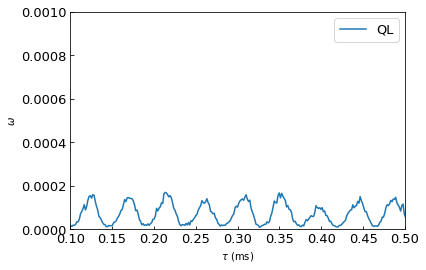

In [975]:
# plt.plot(times, true_trajectory, label='True')
# plt.plot(times, est_trajectory, label='Est.')
plt.plot(times, sweep_outputs[thissweep]["medQL"], label ='QL')

plt.legend(loc='upper right')
plt.xlabel(r'$\tau$ (ms)')
plt.ylabel(r'$\omega$')

# plt.ylim(0.48,0.54)
plt.ylim(0.,0.001)
plt.xlim(0.1,0.5)

plt.show()

In [992]:
print("w0 = ", np.round(0.5/2/PI, 3), " MHz")

w0 =  0.08  MHz


In [1037]:
cm_subsection = np.linspace(0.2, 0.7, 2) 
colors = [cm.viridis(x) for x in cm_subsection]

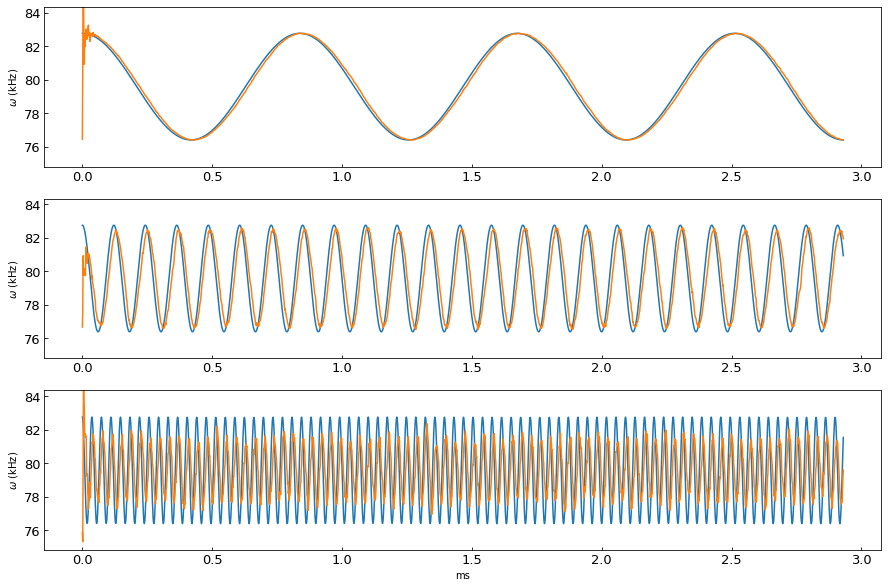

In [1036]:
fig, spl = plt.subplots(3, 1, figsize=(15, 10))

mylist = [2, 15, 50]

khz_convert = 1000/2/PI

for idx in mylist:
    
    thissweep = allfreqrates[idx]
    
    est_trajectory = sweep_outputs[thissweep]["medW"]*khz_convert
    true_trajectory = sweep_outputs[thissweep]["trueW"]*khz_convert

    times = sweep_outputs[thissweep]["simtimes"] + algotimes/convertms
    
    spl[mylist.index(idx)].plot(times, true_trajectory, label='True')
    spl[mylist.index(idx)].plot(times, est_trajectory, label='MFL')
    
    spl[mylist.index(idx)].set_ylim(0.47*khz_convert, 0.53*khz_convert)
    
    spl[mylist.index(idx)].set_ylabel(r'$\omega$ (kHz)')
    
    if mylist.index(idx)+1 == len(mylist):
        spl[mylist.index(idx)].set_xlabel('ms')
    


## Analyse QL behaviour against $\nu$

In [34]:
w02 = 0.5**2

In [35]:
#max_losses = []
med_losses = []
iqr_losses = []

for thissweep in allfreqrates:
    #max_losses.append( max (sweep_outputs[thissweep]["medQL"][50:-1]) )
    med_losses.append( np.median (sweep_outputs[thissweep]["medQL"][50:-1]) )
    iqr_losses.append( [ np.median (sweep_outputs[thissweep]["iqrQLinf"][50:-1]), np.median (sweep_outputs[thissweep]["iqrQLsup"][50:-1]) ] )
    
med_losses = np.array(med_losses)/w02
iqr_losses = np.array(iqr_losses)/w02

In [36]:
med_losses_bin = []
iqr_losses_bin = []

for thissweep in allfreqrates:
    med_losses_bin.append( np.median (sweep_outputs_binomial[thissweep]["medQL"][50:-1]) )
    iqr_losses_bin.append( [ np.median (sweep_outputs_binomial[thissweep]["iqrQLinf"][50:-1]), 
                            np.median (sweep_outputs_binomial[thissweep]["iqrQLsup"][50:-1]) ] )
    
med_losses_bin = np.array(med_losses_bin)/w02
iqr_losses_bin = np.array(iqr_losses_bin)/w02

In [37]:
med_losses_inf = []
iqr_losses_inf = []

for thissweep in allfreqrates:
    med_losses_inf.append( np.median (sweep_outputs_infid[thissweep]["medQL"][50:-1]) )
    iqr_losses_inf.append( [ np.median (sweep_outputs_infid[thissweep]["iqrQLinf"][50:-1]), 
                            np.median (sweep_outputs_infid[thissweep]["iqrQLsup"][50:-1]) ] )
    
med_losses_inf = np.array(med_losses_inf)/w02
iqr_losses_inf = np.array(iqr_losses_inf)/w02

# Plotting QL behaviour against $\nu$

In [38]:
axis_font['size'] = 15
rc('xtick', labelsize=15) 
rc('ytick', labelsize=15) 

rc('legend', fontsize=14) 

In [39]:
times = sweep_outputs[thissweep]["simtimes"] + algotimes/convertms

In [43]:
amp = 0.02
rescalefreqrates = amp*allfreqrates/2/PI*n_experiments/max(times)*10**3 #(in kHz/ms)

err_nontrack = 0.00125664/w02 #from integral averaging

In [44]:
cm_subsection = np.linspace(0.2, 0.7, 2) 
colors = [cm.viridis(x) for x in cm_subsection]

C:\Users\ag15141\Local Documents\Cloud\Dropbox (Qsim)\Qinfer_Sensing\test_results\QHL_sensing_tracking\SinsusoidalSweep_simulation_QLscale___2018-05-25_08.35.36.pdf


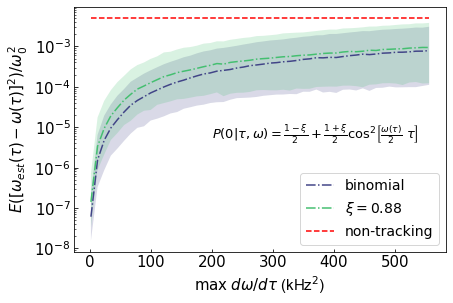

In [51]:
fig = plt.figure(figsize=[4.*5/3, 4.5])

plt.plot(rescalefreqrates, med_losses, linestyle = '-.', color=colors[0], label='binomial')
plt.plot(rescalefreqrates, med_losses_inf, linestyle = '-.', color=colors[1], label=r'$\xi = 0.88$')

plt.plot(rescalefreqrates, np.repeat(err_nontrack, len(rescalefreqrates)), linestyle = '--', color='red', label=r'non-tracking')

plt.fill_between(rescalefreqrates, med_losses+iqr_losses[:,1], med_losses-iqr_losses[:,0],
     alpha=0.2, linewidth=0, facecolor=colors[0], antialiased=True)
plt.fill_between(rescalefreqrates, med_losses_inf+iqr_losses_inf[:,1], med_losses_inf-iqr_losses_inf[:,0],
     alpha=0.2, linewidth=0, facecolor=colors[1], antialiased=True)

plt.yscale('log')

plt.text(200, 5*10**-6, r'$P(0 | \tau, \omega) = \frac{1-\xi}{2} + \frac{1+\xi}{2} \cos^2 \left[ \frac{ \omega(\tau)}{2} \; \tau\right]$', fontsize = 13)

plt.ylabel(r'$E ( [\omega_{est}(\tau) - \omega(\tau)]^2)/ \omega_0^2$', **axis_font)
plt.xlabel(r'$\max \; d\omega/d\tau$ (kHz$^2$)', **axis_font)

plt.legend()

thisfile = 'SinsusoidalSweep_simulation'+"_QLscale__"+timestamp+".pdf"
savefigs(dire, thisfile)

In [62]:
radfreq_to_B(2*PI*0.5)

17.841404189875359